In [1]:
import sys
sys.path.append('../src')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf
from gait.config import pd
from gait.utils import get_data_by_overlap_percent,get_overlap_data_all_sessions,  split_test_train_by_subjects, remove_invalid_data, get_overlap_data_all_sessions
from gait.training import train_model_with_stats, build_cnn_stats_small
from gait.evalution import save_history, save_test_history, save_accuracy_loss_figure, save_confusion_matrix_figure, compute_validations_predictions,compute_validations_predictions_with_stats,compute_validations_predictions_cnn_multihead_with_stats

In [2]:
model = build_cnn_stats_small(128,12,5,np.ones((1, 12)))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 6, 64)    640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 6, 64)   256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [3]:
def compute_resultant_acceleration(X):
    return np.sqrt(X[:,:,0] **2 + X[:,:,1] ** 2 + X[:,:,2] ** 2)

def compute_resultant_gyro(X):
    return np.sqrt(X[:,:,3] **2 + X[:,:,4] ** 2 + X[:,:,5] ** 2)

def compute_resultant_angle(X):
    return np.sqrt(X[:,:,6] **2 + X[:,:,7] ** 2 + X[:,:,8] ** 2)

def get_std_values(X, channel):
    return np.std(X[:, :, channel], axis=1)


def get_mean_values(X, channel):
    return np.mean(X[:, :, channel], axis=1)


def get_max_values(X, channel):
    return np.max(X[:, :, channel], axis=1)

def get_median_values(X, channel):
    return np.median(X[:, :, channel], axis=1)


def get_statistic_feature_all_channels(X):
    statistic_features = []
    for channel in range(9,12):
        statistic_features.append(get_std_values(X, channel))
        statistic_features.append(get_mean_values(X, channel))
        statistic_features.append(get_max_values(X, channel))

    return np.vstack(statistic_features).T

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Statistic feature shape:  (13874, 9)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduc

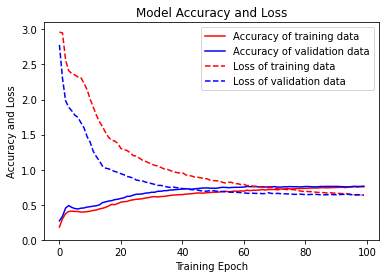

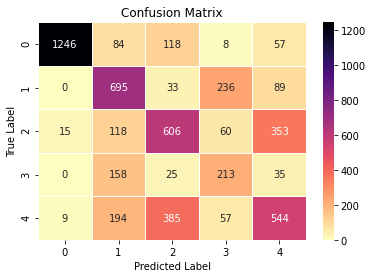

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Statistic feature shape:  (17471, 9)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 64, 6, 64)    640         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 64, 6, 64)   256         ['conv2d_4[0][0]']               
 rmalization)                                       

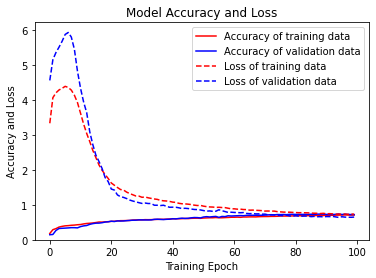

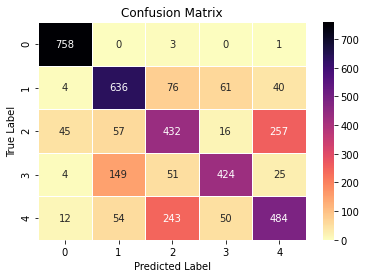

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Statistic feature shape:  (19501, 9)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 64, 6, 64)    640         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 64, 6, 64)   256         ['conv2d_6[0][0]']               
 rmalization)                                       

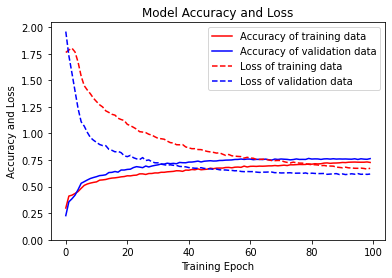

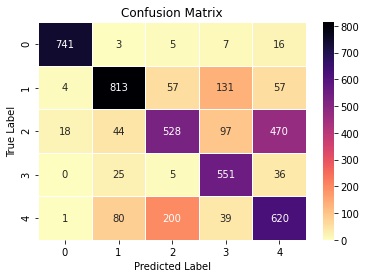

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Statistic feature shape:  (19789, 9)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 64, 6, 64)    640         ['input_9[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 64, 6, 64)   256         ['conv2d_8[0][0]']               
 rmalization)                                       

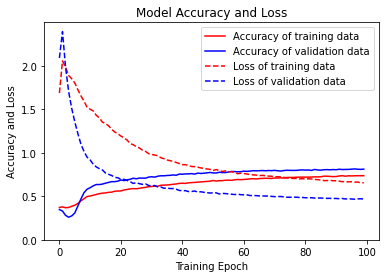

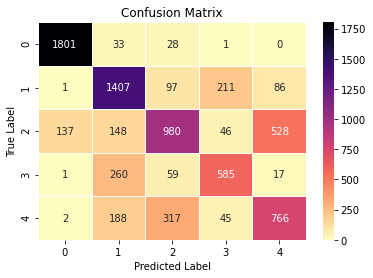

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Statistic feature shape:  (27781, 9)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_10 (Conv2D)             (None, 64, 6, 64)    640         ['input_11[0][0]']               
                                                                                                  
 batch_normalization_10 (BatchN  (None, 64, 6, 64)   256         ['conv2d_10[0][0]']              
 ormalization)                                      

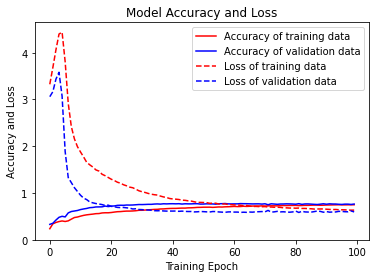

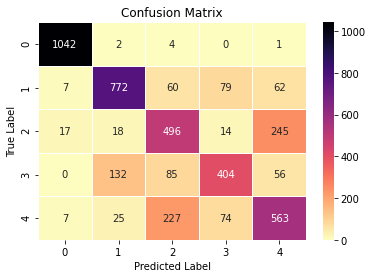

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Statistic feature shape:  (29969, 9)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 64, 6, 64)    640         ['input_13[0][0]']               
                                                                                                  
 batch_normalization_12 (BatchN  (None, 64, 6, 64)   256         ['conv2d_12[0][0]']              
 ormalization)                                      

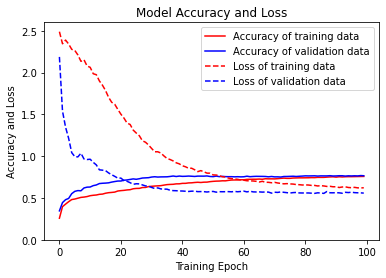

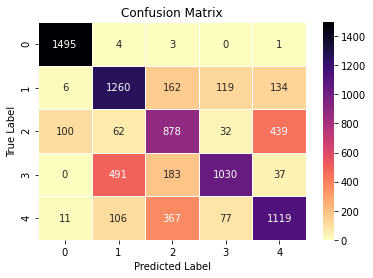

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Statistic feature shape:  (36463, 9)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 64, 6, 64)    640         ['input_15[0][0]']               
                                                                                                  
 batch_normalization_14 (BatchN  (None, 64, 6, 64)   256         ['conv2d_14[0][0]']              
 ormalization)                                      

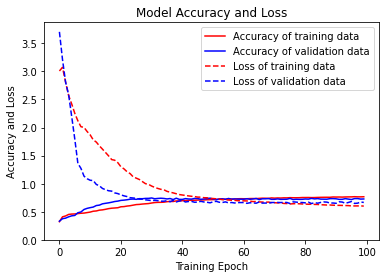

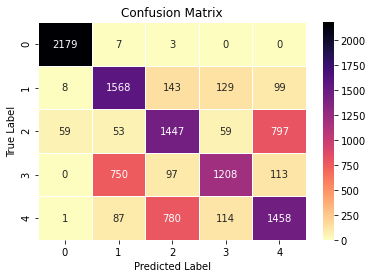

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Statistic feature shape:  (38769, 9)
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 64, 6, 64)    640         ['input_17[0][0]']               
                                                                                                  
 batch_normalization_16 (BatchN  (None, 64, 6, 64)   256         ['conv2d_16[0][0]']              
 ormalization)                                      

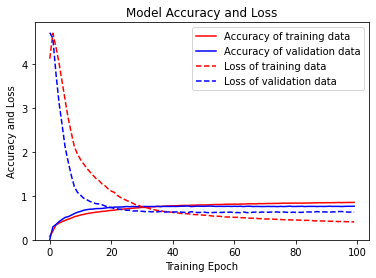

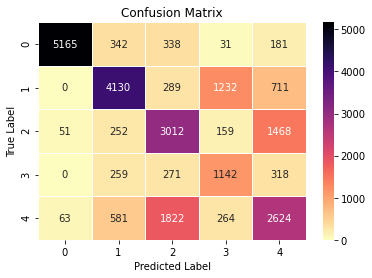

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Statistic feature shape:  (65319, 9)
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 64, 6, 64)    640         ['input_19[0][0]']               
                                                                                                  
 batch_normalization_18 (BatchN  (None, 64, 6, 64)   256         ['conv2d_18[0][0]']              
 ormalization)                                      

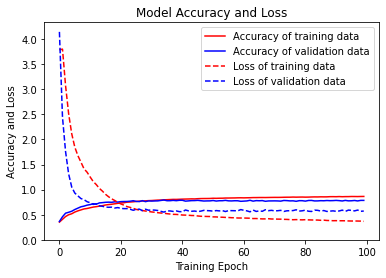

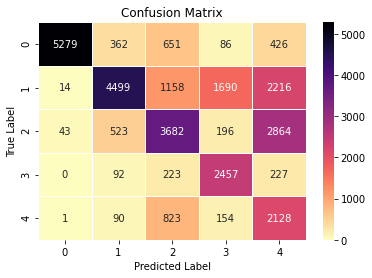

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Statistic feature shape:  (136439, 9)
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 64, 6, 64)    640         ['input_21[0][0]']               
                                                                                                  
 batch_normalization_20 (BatchN  (None, 64, 6, 64)   256         ['conv2d_20[0][0]']              
 ormalization)                                    

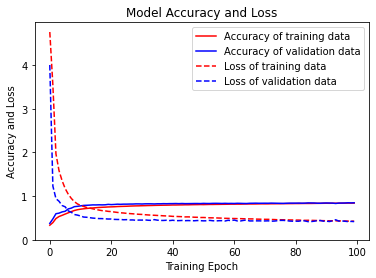

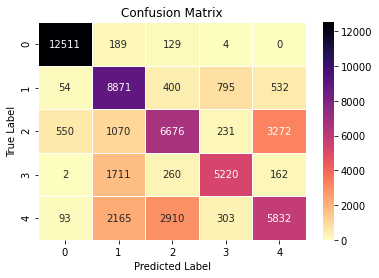

In [4]:
overlapPercents = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
# overlapPercents = [0]
# exclude_subjects = ['ddAeJA42PXvwthbW', 'nan', 'LLZjAPTyj7muHsEf',
#                     'MMuX9YIh4NTbLZLM', 'cbOZWnI7s1y8oLD4', 'PE8D53oX060qLbdX', 'xYdtS1F8tDyjEIgN', 'sUZBISq61Y7I5tqQ']
exclude_subjects = ['ddAeJA42PXvwthbW', 'nan', 'sUZBISq61Y7I5tqQ', 'LLZjAPTyj7muHsEf',
                    'cbOZWnI7s1y8oLD4', 'EUbKPOSQgjccjtvi', 'MMuX9YIh4NTbLZLM', 'NKdnm6cN3KKAx7R4'
                    'PE8D53oX060qLbdX', 'ddAeJA42PXvwthbW', 'xYdtS1F8tDyjEIgN', '19AoxD1bgrDckd2p', 'wtyNo4LYaWXrkzA7', ]

for OVERLAP_PERCENT in overlapPercents:
    gpus = tf.config.list_logical_devices('GPU')
    strategy = tf.distribute.MirroredStrategy(gpus)
    with strategy.scope():
        X, y, subjects = get_overlap_data_all_sessions(OVERLAP_PERCENT)
        # REMOVE UNWANTED SUBJECTS
        indexes = np.where(subjects == exclude_subjects)
        X = np.delete(X, indexes[0], axis=0)
        y = np.delete(y, indexes[0], axis=0)
        subjects = np.delete(subjects, indexes[0], axis=0)
        # END REMOVE UNWANTED SUBJECTS

        # AUGMENT DATA
        resultant_acc = compute_resultant_acceleration(X)
        resultant_gyro = compute_resultant_gyro(X)
        resultant_angle = compute_resultant_angle(X)
        resultant_acc = resultant_acc.reshape(
            resultant_acc.shape[0], resultant_acc.shape[1], 1)
        resultant_gyro = resultant_gyro.reshape(
            resultant_gyro.shape[0], resultant_gyro.shape[1], 1)
        resultant_angle = resultant_angle.reshape(
            resultant_angle.shape[0], resultant_angle.shape[1], 1)
        X = np.concatenate((X, resultant_acc), axis=2)
        X = np.concatenate((X, resultant_gyro), axis=2)
        X = np.concatenate((X, resultant_angle), axis=2)
        # AUGMENT DATA END

        # print('UNIQUE subjects:', np.unique(subjects))
        X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
            X, y, subjects, train_percent=0.8)
        X_train_stats = get_statistic_feature_all_channels(X_train)
        X_test_stats = get_statistic_feature_all_channels(X_test)
        print('Statistic feature shape: ', X_train_stats.shape)
        model, history = train_model_with_stats(
            X_train, y_train, X_test, y_test, X_train_stats, X_test_stats, overlap_percent=OVERLAP_PERCENT, batch_size=128, epochs=100)

        save_history(history, OVERLAP_PERCENT)
        evaluation_history = model.evaluate(
            [X_test, X_test_stats], y_test, batch_size=128, verbose=1)
        save_test_history(evaluation_history, OVERLAP_PERCENT)
        save_accuracy_loss_figure(history, OVERLAP_PERCENT)
        validations, predictions = compute_validations_predictions_with_stats(
            model, X_test, y_test, X_test_stats)
        save_confusion_matrix_figure(
            validations, predictions, OVERLAP_PERCENT, sns)
